In [2]:
############################
# GPU and CPU Check Code
# KEEP AT THE TOP
############################

# !pip install psutil
# !pip install gputil

import os
import time
import torch
import spacy
import psutil
import pandas as pd
import multiprocessing

from functools import partial
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

print("IMPORTS DONE")

IMPORTS DONE


In [3]:
# Get the number of CPUs
num_cpus = psutil.cpu_count(logical=False)  # physical cores
num_logical_cpus = psutil.cpu_count(logical=True)  # logical cores

print(f"Number of physical CPUs: {num_cpus}")
print(f"Number of logical CPUs: {num_logical_cpus}")

try:
    import GPUtil

    # Get the number of available GPUs
    gpus = GPUtil.getGPUs()
    num_gpus = len(gpus)

    print(f"Number of GPUs: {num_gpus}")

    for i, gpu in enumerate(gpus):
        print(f"GPU {i + 1}: {gpu.name}")
        print(f"\tUUID: {gpu.uuid}")
        print(f"\tMemory Total: {gpu.memoryTotal} MB")
        print(f"\tMemory Used: {gpu.memoryUsed} MB")
        print(f"\tMemory Free: {gpu.memoryFree} MB")
        print(f"\tGPU Utilization: {gpu.load * 100}%")
        print(f"\tGPU Temperature: {gpu.temperature} °C")
except ImportError:
    print("GPUtil library not found. Cannot check GPU information.")

Number of physical CPUs: 128
Number of logical CPUs: 128
Number of GPUs: 2
GPU 1: NVIDIA A100 80GB PCIe
	UUID: GPU-37cae1b4-b74a-8497-87be-8fd513b6f069
	Memory Total: 81920.0 MB
	Memory Used: 7.0 MB
	Memory Free: 81042.0 MB
	GPU Utilization: 0.0%
	GPU Temperature: 32.0 °C
GPU 2: NVIDIA A100 80GB PCIe
	UUID: GPU-e3ef0549-20ba-41f6-9e8c-c25c57448650
	Memory Total: 81920.0 MB
	Memory Used: 7.0 MB
	Memory Free: 81042.0 MB
	GPU Utilization: 0.0%
	GPU Temperature: 27.0 °C


## Base Model

In [17]:
# Function to read text files from a directory and assign labels based on directory structure
def read_text_files_from_directory(directory):
    texts = []
    labels = []
    if 'pos' in directory:
        label = 1
    else:
        label = 0
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
            text = file.read().replace('\n', ' ')
            texts.append(text)
            labels.append(label)
    return texts, labels

# Directory paths
train_pos_dir = 'datasets/aclImdb/train/pos/'
train_neg_dir = 'datasets/aclImdb/train/neg/'
test_pos_dir = 'datasets/aclImdb/test/pos/'
test_neg_dir = 'datasets/aclImdb/test/neg/'

# Read positive and negative training data with labels
train_pos_texts, train_pos_labels = read_text_files_from_directory(train_pos_dir)
train_neg_texts, train_neg_labels = read_text_files_from_directory(train_neg_dir)

# Read positive and negative test data with labels
test_pos_texts, test_pos_labels = read_text_files_from_directory(test_pos_dir)
test_neg_texts, test_neg_labels = read_text_files_from_directory(test_neg_dir)

# Process the text data using BERT tokenizer without truncation
def process_text_for_bert(texts):
    formatted_data = []
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            padding='max_length',
            max_length=512,  # Maximum sequence length for BERT
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoded_dict['input_ids']
        attention_mask = encoded_dict['attention_mask']
        token_type_ids = encoded_dict['token_type_ids']

        formatted_data.append({
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids,
        })

    return formatted_data

# Process training and test data
formatted_train_pos = process_text_for_bert(train_pos_texts)
formatted_train_neg = process_text_for_bert(train_neg_texts)
formatted_test_pos = process_text_for_bert(test_pos_texts)
formatted_test_neg = process_text_for_bert(test_neg_texts)

# Convert data to PyTorch tensors
def convert_to_tensors(formatted_data):
    inputs = torch.cat([example['input_ids'] for example in formatted_data], dim=0)
    masks = torch.cat([example['attention_mask'] for example in formatted_data], dim=0)
    token_types = torch.cat([example['token_type_ids'] for example in formatted_data], dim=0)
    return inputs, masks, token_types

train_inputs = torch.cat((convert_to_tensors(formatted_train_pos)[0], convert_to_tensors(formatted_train_neg)[0]), dim=0)
train_masks = torch.cat((convert_to_tensors(formatted_train_pos)[1], convert_to_tensors(formatted_train_neg)[1]), dim=0)
train_token_types = torch.cat((convert_to_tensors(formatted_train_pos)[2], convert_to_tensors(formatted_train_neg)[2]), dim=0)

test_inputs = torch.cat((convert_to_tensors(formatted_test_pos)[0], convert_to_tensors(formatted_test_neg)[0]), dim=0)
test_masks = torch.cat((convert_to_tensors(formatted_test_pos)[1], convert_to_tensors(formatted_test_neg)[1]), dim=0)
test_token_types = torch.cat((convert_to_tensors(formatted_test_pos)[2], convert_to_tensors(formatted_test_neg)[2]), dim=0)

# Labels
train_labels = torch.tensor(train_pos_labels + train_neg_labels)
test_labels = torch.tensor(test_pos_labels + test_neg_labels)

# Define batch size and create DataLoader for training and validation
batch_size = 24

train_dataset = TensorDataset(train_inputs, train_masks, train_token_types, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_inputs, test_masks, test_token_types, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the BERT model and move to GPU if available
model_name = 'bert-base-uncased'
num_labels = 2

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer and learning rate scheduler setup
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)  # AdamW optimizer
total_steps = len(train_dataloader) * num_epochs  # Total number of training steps
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop with training and validation steps (Same as before)
num_epochs = 4  # Set the number of epochs

best_val_accuracy = 0.0
best_epoch = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}:")

    # Training
    model.train()
    total_loss = 0

    for batch_idx, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        inputs, masks, token_types, labels = batch

        optimizer.zero_grad()

        outputs = model(inputs, attention_mask=masks, token_type_ids=token_types)
        logits = outputs.logits

        loss = torch.nn.functional.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update learning rate

        total_loss += loss.item()

        if (batch_idx + 1) % 250 == 0:
            print(f"Processed batch {batch_idx+1}/{len(train_dataloader)}, Loss: {loss.item():.4f}")

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Train Loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in test_dataloader:
            batch = tuple(t.to(device) for t in batch)
            inputs, masks, token_types, labels = batch

            outputs = model(inputs, attention_mask=masks, token_type_ids=token_types)
            logits = outputs.logits

            loss = torch.nn.functional.cross_entropy(logits, labels)
            val_loss += loss.item()

            predictions = torch.argmax(logits, dim=1)
            correct_predictions += torch.sum(predictions == labels).item()

    avg_val_loss = val_loss / len(test_dataloader)
    val_accuracy = correct_predictions / len(test_dataset)

    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')

print(f"Best validation accuracy of {best_val_accuracy:.4f} achieved at epoch {best_epoch + 1}")

# Load the best model and evaluate on the test dataset (Same as before)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Initialize evaluation metrics for the test set (Same as before)
eval_loss = 0
correct_predictions = 0

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    inputs, masks, token_types, labels = batch

    outputs = model(inputs, attention_mask=masks, token_type_ids=token_types)
    logits = outputs.logits

    loss = torch.nn.functional.cross_entropy(logits, labels)
    eval_loss += loss.item()

    predictions = torch.argmax(logits, dim=1)
    correct_predictions += torch.sum(predictions == labels).item()

# Calculate evaluation metrics for the test set (Same as before)
avg_eval_loss = eval_loss / len(test_dataloader)
test_accuracy = correct_predictions / len(test_dataset)
test_error_rate = 1 - test_accuracy

print(f"Test Loss: {avg_eval_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Error Rate: {test_error_rate:.4f}")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Epoch 1/4:
Processed batch 250/1042, Loss: 0.3771
Processed batch 500/1042, Loss: 0.0880
Processed batch 750/1042, Loss: 0.2328
Processed batch 1000/1042, Loss: 0.2763
Train Loss: 0.2342
Validation Loss: 0.1759, Validation Accuracy: 0.9336

Epoch 2/4:
Processed batch 250/1042, Loss: 0.0638
Processed batch 500/1042, Loss: 0.0614
Processed batch 750/1042, Loss: 0.1268
Processed batch 1000/1042, Loss: 0.0495
Train Loss: 0.1116
Validation Loss: 0.1661, Validation Accuracy: 0.9414

Epoch 3/4:
Processed batch 250/1042, Loss: 0.0581
Processed batch 500/1042, Loss: 0.0147
Processed batch 750/1042, Loss: 0.2195
Processed batch 1000/1042, Loss: 0.0325
Train Loss: 0.0503
Validation Loss: 0.2004, Validation Accuracy: 0.9410

Epoch 4/4:
Processed batch 250/1042, Loss: 0.0094
Processed batch 500/1042, Loss: 0.0473
Processed batch 750/1042, Loss: 0.1040
Processed batch 1000/1042, Loss: 0.0022
Train Loss: 0.0253
Validation Loss: 0.2302, Validation Accuracy: 0.9406
Best validation accuracy of 0.9414 a

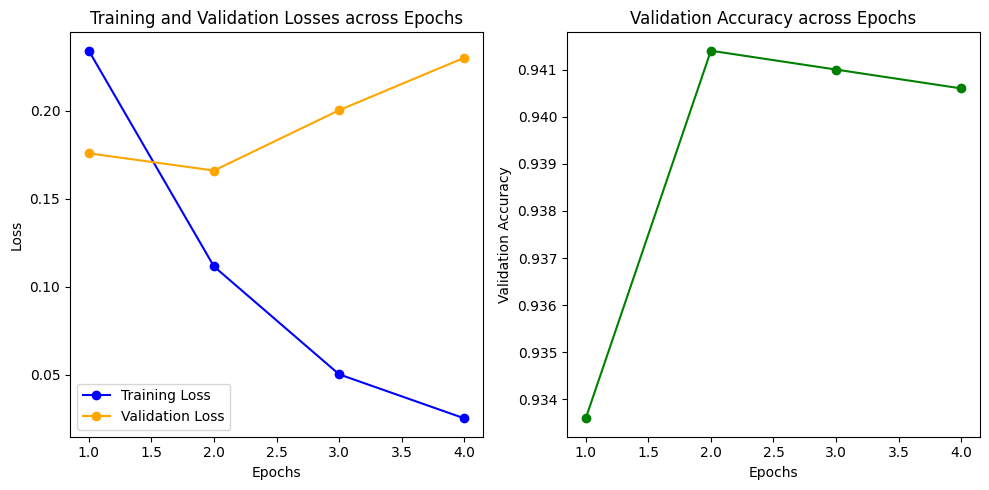

In [7]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4]
train_losses = [0.2342, 0.1116, 0.0503, 0.0253]
validation_losses = [0.1759, 0.1661, 0.2004, 0.2302]
validation_accuracies = [0.9336, 0.9414, 0.9410, 0.9406]

# Plotting training and validation losses across epochs and validation accuracy
plt.figure(figsize=(10, 5))

# Training and Validation Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o', color='blue', label='Training Loss')
plt.plot(epochs, validation_losses, marker='o', color='orange', label='Validation Loss')
plt.title('Training and Validation Losses across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Validation Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, validation_accuracies, marker='o', color='green')
plt.title('Validation Accuracy across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.tight_layout()
plt.show()

## Head-Tail Truncation

In [18]:
# Function to read text files from a directory and assign labels based on directory structure
def read_text_files_from_directory(directory):
    texts = []
    labels = []
    if 'pos' in directory:
        label = 1
    else:
        label = 0
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
            text = file.read().replace('\n', ' ')
            texts.append(text)
            labels.append(label)
    return texts, labels

# Directory paths
train_pos_dir = 'datasets/aclImdb/train/pos/'
train_neg_dir = 'datasets/aclImdb/train/neg/'
test_pos_dir = 'datasets/aclImdb/test/pos/'
test_neg_dir = 'datasets/aclImdb/test/neg/'

# Read positive and negative training data with labels
train_pos_texts, train_pos_labels = read_text_files_from_directory(train_pos_dir)
train_neg_texts, train_neg_labels = read_text_files_from_directory(train_neg_dir)

# Read positive and negative test data with labels
test_pos_texts, test_pos_labels = read_text_files_from_directory(test_pos_dir)
test_neg_texts, test_neg_labels = read_text_files_from_directory(test_neg_dir)

# Process the text data using BERT tokenizer without truncation
def process_text_with_head_tail_truncation(texts):
    formatted_data = []
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    max_seq_length = 512  # Maximum sequence length for BERT
    head_length = 128
    tail_length = 382

    for text in texts:
        head_segment = text[:head_length]
        tail_segment = text[-tail_length:]
        truncated_text = head_segment + tail_segment

        encoded_dict = tokenizer.encode_plus(
            truncated_text,
            add_special_tokens=True,
            max_length=max_seq_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoded_dict['input_ids']
        attention_mask = encoded_dict['attention_mask']
        token_type_ids = encoded_dict['token_type_ids']

        formatted_data.append({
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids,
        })

    return formatted_data

# Process training and test data with head + tail truncation
formatted_train_pos = process_text_with_head_tail_truncation(train_pos_texts)
formatted_train_neg = process_text_with_head_tail_truncation(train_neg_texts)
formatted_test_pos = process_text_with_head_tail_truncation(test_pos_texts)
formatted_test_neg = process_text_with_head_tail_truncation(test_neg_texts)

# Convert data to PyTorch tensors
def convert_to_tensors(formatted_data):
    inputs = torch.cat([example['input_ids'] for example in formatted_data], dim=0)
    masks = torch.cat([example['attention_mask'] for example in formatted_data], dim=0)
    token_types = torch.cat([example['token_type_ids'] for example in formatted_data], dim=0)
    return inputs, masks, token_types

train_inputs = torch.cat((convert_to_tensors(formatted_train_pos)[0], convert_to_tensors(formatted_train_neg)[0]), dim=0)
train_masks = torch.cat((convert_to_tensors(formatted_train_pos)[1], convert_to_tensors(formatted_train_neg)[1]), dim=0)
train_token_types = torch.cat((convert_to_tensors(formatted_train_pos)[2], convert_to_tensors(formatted_train_neg)[2]), dim=0)

test_inputs = torch.cat((convert_to_tensors(formatted_test_pos)[0], convert_to_tensors(formatted_test_neg)[0]), dim=0)
test_masks = torch.cat((convert_to_tensors(formatted_test_pos)[1], convert_to_tensors(formatted_test_neg)[1]), dim=0)
test_token_types = torch.cat((convert_to_tensors(formatted_test_pos)[2], convert_to_tensors(formatted_test_neg)[2]), dim=0)

# Labels
train_labels = torch.tensor(train_pos_labels + train_neg_labels)
test_labels = torch.tensor(test_pos_labels + test_neg_labels)

# Define batch size and create DataLoader for training and validation
batch_size = 24

train_dataset = TensorDataset(train_inputs, train_masks, train_token_types, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_inputs, test_masks, test_token_types, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the BERT model and move to GPU if available
model_name = 'bert-base-uncased'
num_labels = 2

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer and learning rate scheduler setup
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)  # AdamW optimizer
total_steps = len(train_dataloader) * num_epochs  # Total number of training steps
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop with training and validation steps (Same as before)
num_epochs = 4  # Set the number of epochs

best_val_accuracy = 0.0
best_epoch = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}:")

    # Training
    model.train()
    total_loss = 0

    for batch_idx, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        inputs, masks, token_types, labels = batch

        optimizer.zero_grad()

        outputs = model(inputs, attention_mask=masks, token_type_ids=token_types)
        logits = outputs.logits

        loss = torch.nn.functional.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update learning rate

        total_loss += loss.item()

        if (batch_idx + 1) % 250 == 0:
            print(f"Processed batch {batch_idx+1}/{len(train_dataloader)}, Loss: {loss.item():.4f}")

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Train Loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in test_dataloader:
            batch = tuple(t.to(device) for t in batch)
            inputs, masks, token_types, labels = batch

            outputs = model(inputs, attention_mask=masks, token_type_ids=token_types)
            logits = outputs.logits

            loss = torch.nn.functional.cross_entropy(logits, labels)
            val_loss += loss.item()

            predictions = torch.argmax(logits, dim=1)
            correct_predictions += torch.sum(predictions == labels).item()

    avg_val_loss = val_loss / len(test_dataloader)
    val_accuracy = correct_predictions / len(test_dataset)

    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')

print(f"Best validation accuracy of {best_val_accuracy:.4f} achieved at epoch {best_epoch + 1}")

# Load the best model and evaluate on the test dataset (Same as before)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Initialize evaluation metrics for the test set (Same as before)
eval_loss = 0
correct_predictions = 0

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    inputs, masks, token_types, labels = batch

    outputs = model(inputs, attention_mask=masks, token_type_ids=token_types)
    logits = outputs.logits

    loss = torch.nn.functional.cross_entropy(logits, labels)
    eval_loss += loss.item()

    predictions = torch.argmax(logits, dim=1)
    correct_predictions += torch.sum(predictions == labels).item()

# Calculate evaluation metrics for the test set (Same as before)
avg_eval_loss = eval_loss / len(test_dataloader)
test_accuracy = correct_predictions / len(test_dataset)
test_error_rate = 1 - test_accuracy

print(f"Test Loss: {avg_eval_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Error Rate: {test_error_rate:.4f}")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Epoch 1/4:
Processed batch 250/1042, Loss: 0.3637
Processed batch 500/1042, Loss: 0.2401
Processed batch 750/1042, Loss: 0.3386
Processed batch 1000/1042, Loss: 0.2486
Train Loss: 0.2846
Validation Loss: 0.2075, Validation Accuracy: 0.9171

Epoch 2/4:
Processed batch 250/1042, Loss: 0.3306
Processed batch 500/1042, Loss: 0.1163
Processed batch 750/1042, Loss: 0.2387
Processed batch 1000/1042, Loss: 0.1176
Train Loss: 0.1386
Validation Loss: 0.2084, Validation Accuracy: 0.9226

Epoch 3/4:
Processed batch 250/1042, Loss: 0.0885
Processed batch 500/1042, Loss: 0.1229
Processed batch 750/1042, Loss: 0.0219
Processed batch 1000/1042, Loss: 0.0202
Train Loss: 0.0578
Validation Loss: 0.2523, Validation Accuracy: 0.9198

Epoch 4/4:
Processed batch 250/1042, Loss: 0.0830
Processed batch 500/1042, Loss: 0.0039
Processed batch 750/1042, Loss: 0.0030
Processed batch 1000/1042, Loss: 0.0033
Train Loss: 0.0231
Validation Loss: 0.3005, Validation Accuracy: 0.9232
Best validation accuracy of 0.9232 a

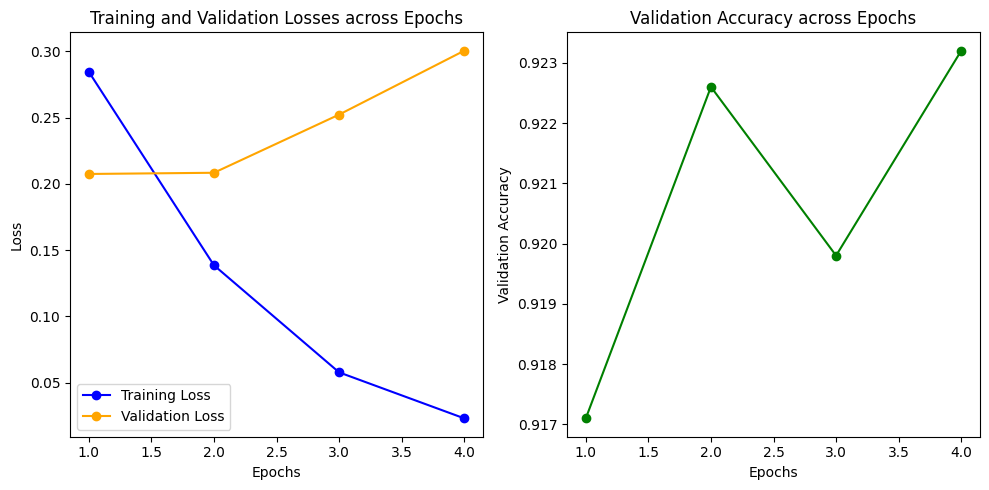

In [8]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4]
train_losses = [0.2846, 0.1386, 0.0578, 0.0231]
validation_losses = [0.2075, 0.2084, 0.2523, 0.3005]
validation_accuracies = [0.9171, 0.9226, 0.9198, 0.9232]

# Plotting training and validation losses across epochs and validation accuracy
plt.figure(figsize=(10, 5))

# Training and Validation Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o', color='blue', label='Training Loss')
plt.plot(epochs, validation_losses, marker='o', color='orange', label='Validation Loss')
plt.title('Training and Validation Losses across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Validation Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, validation_accuracies, marker='o', color='green')
plt.title('Validation Accuracy across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.tight_layout()
plt.show()

## Extracting and Finetuning Features from Last Layer

In [4]:
# Function to read text files from a directory and assign labels based on directory structure
def read_text_files_from_directory(directory):
    texts = []
    labels = []
    if 'pos' in directory:
        label = 1
    else:
        label = 0
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
            text = file.read().replace('\n', ' ')
            texts.append(text)
            labels.append(label)
    return texts, labels

# Directory paths
train_pos_dir = 'datasets/aclImdb/train/pos/'
train_neg_dir = 'datasets/aclImdb/train/neg/'
test_pos_dir = 'datasets/aclImdb/test/pos/'
test_neg_dir = 'datasets/aclImdb/test/neg/'

# Read positive and negative training data with labels
train_pos_texts, train_pos_labels = read_text_files_from_directory(train_pos_dir)
train_neg_texts, train_neg_labels = read_text_files_from_directory(train_neg_dir)

# Read positive and negative test data with labels
test_pos_texts, test_pos_labels = read_text_files_from_directory(test_pos_dir)
test_neg_texts, test_neg_labels = read_text_files_from_directory(test_neg_dir)

def process_text_with_head_tail_truncation(texts):
    formatted_data = []
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    max_seq_length = 512  # Maximum sequence length for BERT
    head_length = 128
    tail_length = 382

    for text in texts:
        head_segment = text[:head_length]
        tail_segment = text[-tail_length:]
        truncated_text = head_segment + tail_segment

        encoded_dict = tokenizer.encode_plus(
            truncated_text,
            add_special_tokens=True,
            max_length=max_seq_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoded_dict['input_ids']
        attention_mask = encoded_dict['attention_mask']
        token_type_ids = encoded_dict['token_type_ids']

        formatted_data.append({
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids,
        })

    return formatted_data

# Process training and test data with head + tail truncation
formatted_train_pos = process_text_with_head_tail_truncation(train_pos_texts)
formatted_train_neg = process_text_with_head_tail_truncation(train_neg_texts)
formatted_test_pos = process_text_with_head_tail_truncation(test_pos_texts)
formatted_test_neg = process_text_with_head_tail_truncation(test_neg_texts)

# Convert data to PyTorch tensors
def convert_to_tensors(formatted_data):
    inputs = torch.cat([example['input_ids'] for example in formatted_data], dim=0)
    masks = torch.cat([example['attention_mask'] for example in formatted_data], dim=0)
    token_types = torch.cat([example['token_type_ids'] for example in formatted_data], dim=0)
    return inputs, masks, token_types

train_inputs = torch.cat((convert_to_tensors(formatted_train_pos)[0], convert_to_tensors(formatted_train_neg)[0]), dim=0)
train_masks = torch.cat((convert_to_tensors(formatted_train_pos)[1], convert_to_tensors(formatted_train_neg)[1]), dim=0)
train_token_types = torch.cat((convert_to_tensors(formatted_train_pos)[2], convert_to_tensors(formatted_train_neg)[2]), dim=0)

test_inputs = torch.cat((convert_to_tensors(formatted_test_pos)[0], convert_to_tensors(formatted_test_neg)[0]), dim=0)
test_masks = torch.cat((convert_to_tensors(formatted_test_pos)[1], convert_to_tensors(formatted_test_neg)[1]), dim=0)
test_token_types = torch.cat((convert_to_tensors(formatted_test_pos)[2], convert_to_tensors(formatted_test_neg)[2]), dim=0)

# Labels (Same as before)
train_labels = torch.tensor(train_pos_labels + train_neg_labels)
test_labels = torch.tensor(test_pos_labels + test_neg_labels)

# Define batch size and create DataLoader for training and testing (Same as before)
batch_size = 24

train_dataset = TensorDataset(train_inputs, train_masks, train_token_types, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_inputs, test_masks, test_token_types, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# Initialize the BERT model and move to GPU if available
model_name = 'bert-base-uncased'
num_labels = 2

model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Choose the specific layer to fine-tune (example: the last layer)
for param in model.bert.parameters():  # Freeze all BERT parameters
    param.requires_grad = False

for param in model.bert.encoder.layer[-1].parameters():  # Make the last layer trainable
    param.requires_grad = True

# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)

total_steps = len(train_dataloader) * 4  # 4 epochs
warmup_steps = int(total_steps * 0.1)  # 10% of total steps for warm-up

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Training loop with training and validation steps
num_epochs = 4  # Set the number of epochs

best_val_accuracy = 0.0
best_epoch = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}:")

    # Training
    model.train()
    total_loss = 0

    for batch_idx, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        inputs, masks, token_types, labels = batch

        optimizer.zero_grad()

        outputs = model(inputs, attention_mask=masks, token_type_ids=token_types)
        logits = outputs.logits

        loss = torch.nn.functional.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update learning rate

        total_loss += loss.item()

        if (batch_idx + 1) % 250 == 0:
            print(f"Processed batch {batch_idx+1}/{len(train_dataloader)}, Loss: {loss.item():.4f}")

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Train Loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in test_dataloader:
            batch = tuple(t.to(device) for t in batch)
            inputs, masks, token_types, labels = batch

            outputs = model(inputs, attention_mask=masks, token_type_ids=token_types)
            logits = outputs.logits

            loss = torch.nn.functional.cross_entropy(logits, labels)
            val_loss += loss.item()

            predictions = torch.argmax(logits, dim=1)
            correct_predictions += torch.sum(predictions == labels).item()

    avg_val_loss = val_loss / len(test_dataloader)
    val_accuracy = correct_predictions / len(test_dataset)

    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')

print(f"Best validation accuracy of {best_val_accuracy:.4f} achieved at epoch {best_epoch + 1}")

# Load the best model and evaluate on the test dataset
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Evaluation on the test set
eval_loss = 0
correct_predictions = 0

with torch.no_grad():
    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs, masks, token_types, labels = batch

        outputs = model(inputs, attention_mask=masks, token_type_ids=token_types)
        logits = outputs.logits

        loss = torch.nn.functional.cross_entropy(logits, labels)
        eval_loss += loss.item()

        predictions = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(predictions == labels).item()

# Calculate evaluation metrics for the test set
avg_eval_loss = eval_loss / len(test_dataloader)
test_accuracy = correct_predictions / len(test_dataset)
test_error_rate = 1 - test_accuracy

print(f"Test Loss: {avg_eval_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Error Rate: {test_error_rate:.4f}")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Epoch 1/4:
Processed batch 250/1042, Loss: 0.6164
Processed batch 500/1042, Loss: 0.6018
Processed batch 750/1042, Loss: 0.5237
Processed batch 1000/1042, Loss: 0.2165
Train Loss: 0.4391
Validation Loss: 0.2990, Validation Accuracy: 0.8745

Epoch 2/4:
Processed batch 250/1042, Loss: 0.3428
Processed batch 500/1042, Loss: 0.4036
Processed batch 750/1042, Loss: 0.3348
Processed batch 1000/1042, Loss: 0.4916
Train Loss: 0.3021
Validation Loss: 0.2687, Validation Accuracy: 0.8889

Epoch 3/4:
Processed batch 250/1042, Loss: 0.2959
Processed batch 500/1042, Loss: 0.1929
Processed batch 750/1042, Loss: 0.1150
Processed batch 1000/1042, Loss: 0.3263
Train Loss: 0.2824
Validation Loss: 0.2612, Validation Accuracy: 0.8924

Epoch 4/4:
Processed batch 250/1042, Loss: 0.1515
Processed batch 500/1042, Loss: 0.2305
Processed batch 750/1042, Loss: 0.1578
Processed batch 1000/1042, Loss: 0.4576
Train Loss: 0.2712
Validation Loss: 0.2580, Validation Accuracy: 0.8929
Best validation accuracy of 0.8929 a

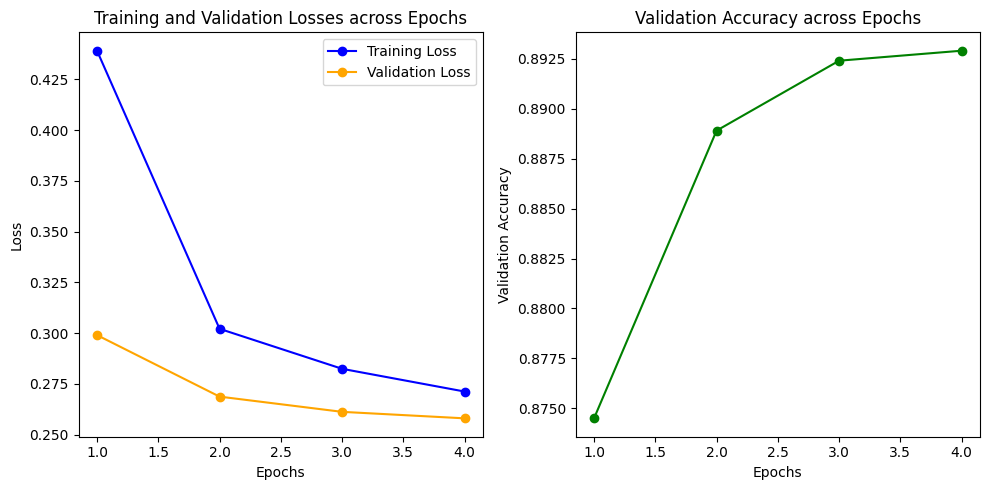

In [10]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4]
train_losses = [0.4391, 0.3021, 0.2824, 0.2712]
validation_losses = [0.2990, 0.2687, 0.2612, 0.2580]
validation_accuracies = [0.8745, 0.8889, 0.8924, 0.8929]

# Plotting training and validation losses across epochs and validation accuracy
plt.figure(figsize=(10, 5))

# Training and Validation Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o', color='blue', label='Training Loss')
plt.plot(epochs, validation_losses, marker='o', color='orange', label='Validation Loss')
plt.title('Training and Validation Losses across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Validation Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, validation_accuracies, marker='o', color='green')
plt.title('Validation Accuracy across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.tight_layout()
plt.show()

## Decreasing Learning Rate Based on Layers

In [21]:
# Function to read text files from a directory and assign labels based on directory structure
def read_text_files_from_directory(directory):
    texts = []
    labels = []
    if 'pos' in directory:
        label = 1
    else:
        label = 0
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
            text = file.read().replace('\n', ' ')
            texts.append(text)
            labels.append(label)
    return texts, labels

# Directory paths
train_pos_dir = 'datasets/aclImdb/train/pos/'
train_neg_dir = 'datasets/aclImdb/train/neg/'
test_pos_dir = 'datasets/aclImdb/test/pos/'
test_neg_dir = 'datasets/aclImdb/test/neg/'

# Read positive and negative training data with labels
train_pos_texts, train_pos_labels = read_text_files_from_directory(train_pos_dir)
train_neg_texts, train_neg_labels = read_text_files_from_directory(train_neg_dir)

# Read positive and negative test data with labels
test_pos_texts, test_pos_labels = read_text_files_from_directory(test_pos_dir)
test_neg_texts, test_neg_labels = read_text_files_from_directory(test_neg_dir)

def process_text_with_head_tail_truncation(texts):
    formatted_data = []
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    max_seq_length = 512  # Maximum sequence length for BERT
    head_length = 128
    tail_length = 382

    for text in texts:
        head_segment = text[:head_length]
        tail_segment = text[-tail_length:]
        truncated_text = head_segment + tail_segment

        encoded_dict = tokenizer.encode_plus(
            truncated_text,
            add_special_tokens=True,
            max_length=max_seq_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoded_dict['input_ids']
        attention_mask = encoded_dict['attention_mask']
        token_type_ids = encoded_dict['token_type_ids']

        formatted_data.append({
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids,
        })

    return formatted_data

# Process training and test data with head + tail truncation
formatted_train_pos = process_text_with_head_tail_truncation(train_pos_texts)
formatted_train_neg = process_text_with_head_tail_truncation(train_neg_texts)
formatted_test_pos = process_text_with_head_tail_truncation(test_pos_texts)
formatted_test_neg = process_text_with_head_tail_truncation(test_neg_texts)

# Convert data to PyTorch tensors
def convert_to_tensors(formatted_data):
    inputs = torch.cat([example['input_ids'] for example in formatted_data], dim=0)
    masks = torch.cat([example['attention_mask'] for example in formatted_data], dim=0)
    token_types = torch.cat([example['token_type_ids'] for example in formatted_data], dim=0)
    return inputs, masks, token_types

train_inputs = torch.cat((convert_to_tensors(formatted_train_pos)[0], convert_to_tensors(formatted_train_neg)[0]), dim=0)
train_masks = torch.cat((convert_to_tensors(formatted_train_pos)[1], convert_to_tensors(formatted_train_neg)[1]), dim=0)
train_token_types = torch.cat((convert_to_tensors(formatted_train_pos)[2], convert_to_tensors(formatted_train_neg)[2]), dim=0)

test_inputs = torch.cat((convert_to_tensors(formatted_test_pos)[0], convert_to_tensors(formatted_test_neg)[0]), dim=0)
test_masks = torch.cat((convert_to_tensors(formatted_test_pos)[1], convert_to_tensors(formatted_test_neg)[1]), dim=0)
test_token_types = torch.cat((convert_to_tensors(formatted_test_pos)[2], convert_to_tensors(formatted_test_neg)[2]), dim=0)

# Labels (Same as before)
train_labels = torch.tensor(train_pos_labels + train_neg_labels)
test_labels = torch.tensor(test_pos_labels + test_neg_labels)

# Define batch size and create DataLoader for training and testing (Same as before)
batch_size = 24

train_dataset = TensorDataset(train_inputs, train_masks, train_token_types, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_inputs, test_masks, test_token_types, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [22]:
# Initialize BERT model for sequence classification
model_name = 'bert-base-uncased'
num_labels = 2

model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define base learning rate and decay factor
base_learning_rate = 2e-5
decay_factor = 0.95

# Assigning layer-wise learning rates
optimizer_grouped_parameters = []
lr = base_learning_rate

for layer in range(12):  # Assuming 12 layers in BERT
    optimizer_grouped_parameters.append(
        {'params': model.bert.encoder.layer[layer].parameters(), 'lr': lr}
    )
    lr *= decay_factor  # Update LR for the next layer

# Add optimizer and scheduler initialization
optimizer = AdamW(optimizer_grouped_parameters)
# Define total_steps, warmup_steps, num_epochs, etc. as needed

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Training and evaluation loops
num_epochs = 4  # Set the number of epochs

best_val_accuracy = 0.0
best_epoch = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}:")

    # Training loop
    model.train()
    total_loss = 0

    for batch_idx, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        inputs, masks, token_types, labels = batch

        optimizer.zero_grad()

        outputs = model(inputs, attention_mask=masks, token_type_ids=token_types)
        logits = outputs.logits

        loss = torch.nn.functional.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update learning rate

        total_loss += loss.item()

        if (batch_idx + 1) % 250 == 0:
            print(f"Processed batch {batch_idx+1}/{len(train_dataloader)}, Loss: {loss.item():.4f}")

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Train Loss: {avg_train_loss:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in test_dataloader:
            batch = tuple(t.to(device) for t in batch)
            inputs, masks, token_types, labels = batch

            outputs = model(inputs, attention_mask=masks, token_type_ids=token_types)
            logits = outputs.logits

            loss = torch.nn.functional.cross_entropy(logits, labels)
            val_loss += loss.item()

            predictions = torch.argmax(logits, dim=1)
            correct_predictions += torch.sum(predictions == labels).item()

        avg_val_loss = val_loss / len(test_dataloader)
        val_accuracy = correct_predictions / len(test_dataset)

        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_epoch = epoch
            # Save the best model
            torch.save(model.state_dict(), 'best_model.pth')

print(f"Best validation accuracy of {best_val_accuracy:.4f} achieved at epoch {best_epoch + 1}")

# Load the best model and evaluate on the test dataset
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Initialize evaluation metrics for the test set
eval_loss = 0
correct_predictions = 0

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    inputs, masks, token_types, labels = batch

    outputs = model(inputs, attention_mask=masks, token_type_ids=token_types)
    logits = outputs.logits

    loss = torch.nn.functional.cross_entropy(logits, labels)
    eval_loss += loss.item()

    predictions = torch.argmax(logits, dim=1)
    correct_predictions += torch.sum(predictions == labels).item()

# Calculate evaluation metrics for the test set
avg_eval_loss = eval_loss / len(test_dataloader)
test_accuracy = correct_predictions / len(test_dataset)
test_error_rate = 1 - test_accuracy

print(f"Test Loss: {avg_eval_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Error Rate: {test_error_rate:.4f}")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Epoch 1/4:
Processed batch 250/1042, Loss: 0.3973
Processed batch 500/1042, Loss: 0.4854
Processed batch 750/1042, Loss: 0.2704
Processed batch 1000/1042, Loss: 0.1493
Train Loss: 0.3853
Validation Loss: 0.2200, Validation Accuracy: 0.9130

Epoch 2/4:
Processed batch 250/1042, Loss: 0.4537
Processed batch 500/1042, Loss: 0.0846
Processed batch 750/1042, Loss: 0.2624
Processed batch 1000/1042, Loss: 0.3348
Train Loss: 0.1859
Validation Loss: 0.2034, Validation Accuracy: 0.9222

Epoch 3/4:
Processed batch 250/1042, Loss: 0.0689
Processed batch 500/1042, Loss: 0.0672
Processed batch 750/1042, Loss: 0.0616
Processed batch 1000/1042, Loss: 0.0775
Train Loss: 0.1070
Validation Loss: 0.2273, Validation Accuracy: 0.9227

Epoch 4/4:
Processed batch 250/1042, Loss: 0.0428
Processed batch 500/1042, Loss: 0.0182
Processed batch 750/1042, Loss: 0.0175
Processed batch 1000/1042, Loss: 0.0221
Train Loss: 0.0686
Validation Loss: 0.2478, Validation Accuracy: 0.9222
Best validation accuracy of 0.9227 a

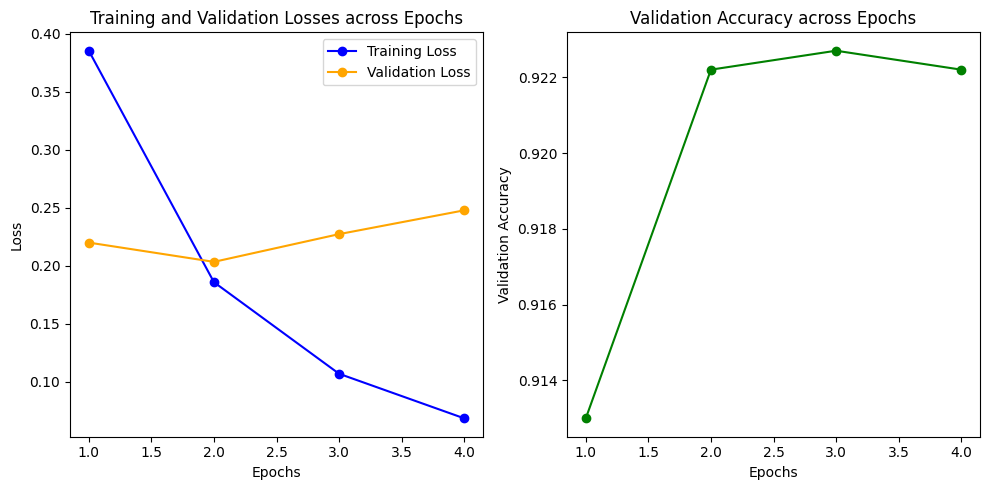

In [11]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4]
train_losses = [0.3853, 0.1859, 0.1070, 0.0686]
validation_losses = [0.2200, 0.2034, 0.2273, 0.2478]
validation_accuracies = [0.9130, 0.9222, 0.9227, 0.9222]

# Plotting training and validation losses across epochs and validation accuracy
plt.figure(figsize=(10, 5))

# Training and Validation Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o', color='blue', label='Training Loss')
plt.plot(epochs, validation_losses, marker='o', color='orange', label='Validation Loss')
plt.title('Training and Validation Losses across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Validation Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, validation_accuracies, marker='o', color='green')
plt.title('Validation Accuracy across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.tight_layout()
plt.show()

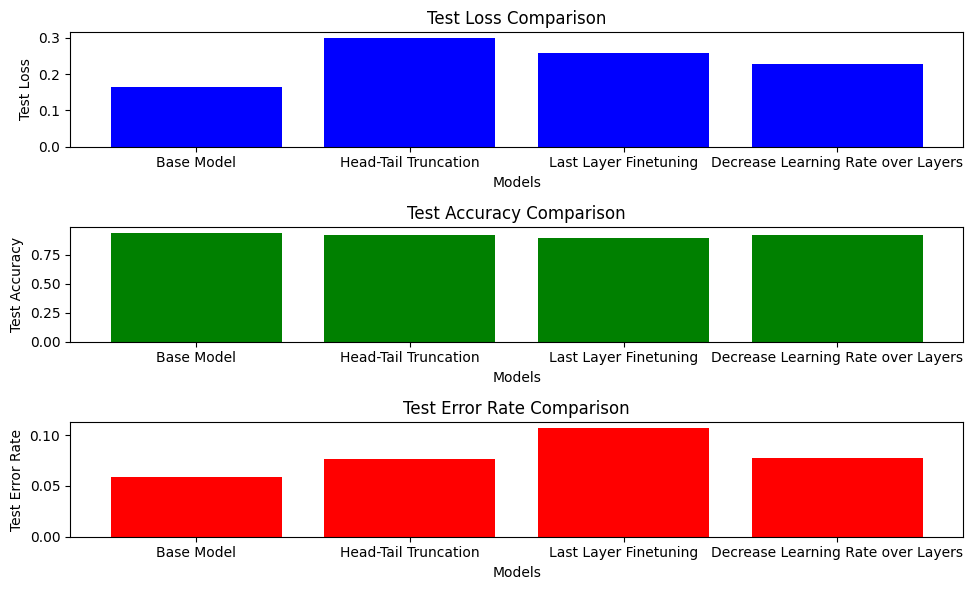

In [12]:
import matplotlib.pyplot as plt

models = ['Base Model', 'Head-Tail Truncation', 'Last Layer Finetuning', 'Decrease Learning Rate over Layers']
test_loss = [0.1661, 0.3005, 0.2580, 0.2273]
test_accuracy = [0.9414, 0.9232, 0.8929, 0.9227]
test_error_rate = [0.0586, 0.0768, 0.1071, 0.0773]

# Creating subplots for each metric
plt.figure(figsize=(10, 6))

# Test Loss
plt.subplot(3, 1, 1)
plt.bar(models, test_loss, color='blue')
plt.title('Test Loss Comparison')
plt.xlabel('Models')
plt.ylabel('Test Loss')

# Test Accuracy
plt.subplot(3, 1, 2)
plt.bar(models, test_accuracy, color='green')
plt.title('Test Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Test Accuracy')

# Test Error Rate
plt.subplot(3, 1, 3)
plt.bar(models, test_error_rate, color='red')
plt.title('Test Error Rate Comparison')
plt.xlabel('Models')
plt.ylabel('Test Error Rate')

plt.tight_layout()
plt.show()